# Data Preprocessing - Thesis
### Import Relevant Modules

In [1]:
import pandas as pd 
from pathlib import Path
import os 
from datetime import datetime as dt
import yfinance as yf
from tqdm.notebook import tqdm
import numpy as np
tqdm.pandas()
import nltk
import gensim
import gensim.corpora as corpora
from gensim import models
import datetime
import statsmodels as sm
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import string
stop = stopwords.words("english")
stop.extend(["the", "would", "in", "also", "noted", "committee", "participants", "members", "periods"])
import re
from fredapi import Fred
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import warnings 
warnings.filterwarnings("ignore")

## Load in Text Data (Scraped Minutes)

In [2]:
# get the files
path = (Path().cwd() / 'Minutes')
files = path.glob('*.txt')

# write the text from each file into a list with a list comprehension - the file is opened and closed
text = [f.read_text(encoding="utf8") for f in files]
dates = os.listdir(path)

In [3]:
new_dates = []
for date in dates:
    i = date[:8]
    i = pd.to_datetime(i)
    new_dates.append(i)

In [4]:
minutes = pd.DataFrame(text, columns = ["Minutes"], index = new_dates)
minutes_clean = minutes.copy()
minutes.head()

,Minutes
1996-01-30,A meeting of the Federal Open Market Committee...
1996-03-26,A meeting of the Federal Open Market Committee...
1996-05-21,A meeting of the Federal Open Market Committee...
1996-07-02,A meeting of the Federal Open Market Committee...
1996-08-20,A meeting of the Federal Open Market Committee...


In [5]:
print(minutes["Minutes"][1][195:1000])
# Clearly a lot of noise due to non-policy related text (list of attendees in the meeting, voting description etc)


[SECTION]

Messrs. Broaddus, Guynn, Moskow, and Parry,

                       Alternate Members of the Federal Open Market

                       Committee

[SECTION]

Messrs. Hoenig and Melzer, and Ms. Minehan,

                       Presidents of the Federal Reserve Banks of

                       Kansas City, St. Louis, and Boston

                       respectively

[SECTION]

Mr. Kohn, Secretary and Economist



		Mr. Bernard, Deputy Secretary



		Mr. Coyne, Assistant Secretary



		Mr. Gillum, Assistant Secretary



		Mr. Mattingly, General Counsel



		Mr. Baxter, Deputy General Counsel



		Mr. Prell, Economist



		Mr. Truman, Economist

[SECTION]

Messrs. Lang, Mishkin, Promisel, Rolnick,

                       Rosenblum, Siegman, Simpson, Sniderman, and

                     


## Data Generation

### Helper Functions

In [6]:
def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.strftime(x, '%Y-%m-%d')
        except:
            return None
    x = pd.to_datetime(x)
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

def get_recession(x):
    if type(x) is str:
        try:
            x = dt.strftime(x, '%Y-%m-%d')
        except:
            return None
    x = pd.to_datetime(x)
    return recessions.loc[x][0]

def get_rate(x):
    if type(x) is str:
        try:
            x = dt.strftime(x, '%Y-%m-%d')
        except:
            return None
    x = pd.to_datetime(x)
    return ffr.loc[x][0]

def get_taylor(x):
    if type(x) is str:
        try:
            x = dt.strftime(x, '%Y-%m-%d')
        except:
            return None
    x = pd.to_datetime(x)
    if x in taylor.index:
        return taylor.loc[x][0]
    else:
        return None

In [7]:
def reorganize_df(df):
    '''
    '''
    
    temp_dict = {
        'chairperson': df.index.map(lambda x: get_chairperson(x)),
        'word_count': df['Minutes'].map(get_word_count),
        'org_text': df['Minutes'],
        'text_sections': df['Minutes'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'recession': df.index.map(lambda x: get_recession(x)),
        'rate': df.index.map(lambda x: get_rate(x)),
        'taylor': df.index.map(lambda x: get_taylor(x))
    }

    new_df = pd.DataFrame(temp_dict, index = df.index)
    print("Shape of the dataframe: ", new_df.shape)
    return new_df

Now lets load in the key additional datapoints, such as recessions and chairpeople 

### Recessions 

In [8]:
# Downloading using FRED API
fred = Fred(api_key = "e1d6df5228083eabdd27bd113d0214c1")
recessions = pd.DataFrame(fred.get_series("USREC"))

# Upsampling data- monthly to daily, for analysis
start_date = minutes.index.min()
end_date = minutes.index.max() + pd.DateOffset(day=31)

dates = pd.date_range(start_date, end_date, freq="D")
dates.name = "Date"
recessions = recessions.reindex(dates, method="ffill")
recessions.head()

,0
Date,
1996-01-30,0.0
1996-01-31,0.0
1996-02-01,0.0
1996-02-02,0.0
1996-02-03,0.0


### Fed Funds Rate

In [9]:
ffr = pd.DataFrame(fred.get_series("FEDFUNDS"))

start_date = minutes.index.min()
end_date = minutes.index.max() + pd.DateOffset(day=31)

dates = pd.date_range(start_date, end_date, freq="D")
dates.name = "Date"
ffr = ffr.reindex(dates, method="ffill")
ffr.tail()

,0
Date,
2022-12-27,4.1
2022-12-28,4.1
2022-12-29,4.1
2022-12-30,4.1
2022-12-31,4.1


### Taylor Rule

In [10]:
#original = inflation + 0.5(output_gap) + 0.5(inflation - target)

taylor = pd.read_csv(r"C:\Users\Csome\OneDrive\Documents\Economics Final Year\Easy_FRED.csv")
taylor = taylor.set_index(pd.to_datetime(taylor['Date'], format='%d/%m/%Y'))
taylor = taylor.drop("Date", axis = 1)
taylor = taylor.resample('D').interpolate(method='ffill')

taylor.tail()

,GDP_Taylor
Date,
2022-11-11,6.398823
2022-11-12,6.398823
2022-11-13,6.398823
2022-11-14,6.398823
2022-11-15,6.372595


### FOMC Chairperson 

In [11]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt(1979,8,6), dt(1987,8,10)],
          ["Greenspan", "Alan", dt(1987,8,11), dt(2006,1,31)], 
          ["Bernanke", "Ben", dt(2006,2,1), dt(2014,1,31)], 
          ["Yellen", "Janet", dt(2014,2,3), dt(2018,2,3)],
          ["Powell", "Jerome", dt(2018,2,5), dt(2023,2,9)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2023-02-09


In [12]:
cleaning_mins = reorganize_df(minutes)
cleaning_mins.head()

Shape of the dataframe:  (215, 7)


,chairperson,word_count,org_text,text_sections,recession,rate,taylor
1996-01-30,Alan Greenspan,9403,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,0.0,5.56,3.740709
1996-03-26,Alan Greenspan,4237,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,0.0,5.31,3.488009
1996-05-21,Alan Greenspan,4351,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,0.0,5.24,3.959658
1996-07-02,Alan Greenspan,5507,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,0.0,5.40,3.959658
1996-08-20,Alan Greenspan,3810,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,0.0,5.22,3.987449


<AxesSubplot:>

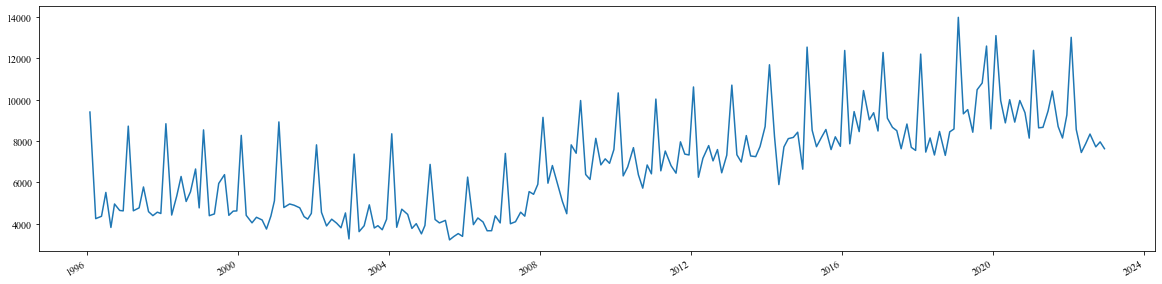

In [13]:
cleaning_mins.word_count.plot(figsize=(20, 5))

Now we have some fun data, lets do some processing. ***Garbage in, garbage out***

## Text Cleaning

In [14]:
# Lets preprocess 
def remove_short_sections(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    '''
    new_df = df.copy()
    new_text_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text_section.append(section)
                
        new_text_section_list.append(new_text_section)
        
    new_df['text_sections'] = new_text_section_list
    
    return new_df

def concatenate_sections(df):
    '''
    Using 'text_sections' of the given dataframe, concatenate sections with a space.
    '''
    new_df = df.copy()
    new_text_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
                
        for section in row['text_sections']:
            new_text += " " + section
                
        new_text_list.append(new_text.strip())
        
    new_df['text'] = new_text_list
    
    return new_df


def clean_text(text):
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    # Remove punctuation
    punc = list(string.punctuation)
    punc_free = "".join([i for i in text if i not in punc])
    # Remove stopwords and non-alphabetic characters
    cleaned_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop]
    return cleaned_tokens


def update_word_count(df):
    '''
    Using 'text' of the given dataframe, update 'word_count' column.
    '''
    new_df = df.copy()
    new_wc_list = []
    clean = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        cleaned_text = clean_text(row['text'])
        clean.append(cleaned_text)
        new_wc_list.append(len(cleaned_text))
        
    new_df['word_count'] = new_wc_list
    new_df['text'] = clean
    
    return new_df

In [15]:
cleaned_mins = remove_short_sections(cleaning_mins)
cleaned_mins = concatenate_sections(cleaned_mins)
cleaned_mins = update_word_count(cleaned_mins)
cleaned_mins.head()

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

,chairperson,word_count,org_text,text_sections,recession,rate,taylor,text
1996-01-30,Alan Greenspan,4023,A meeting of the Federal Open Market Committee...,"[Gary H. Stern, President of the Federal Reser...",0.0,5.56,3.740709,"[gary, stern, president, federal, reserve, ban..."
1996-03-26,Alan Greenspan,2027,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.31,3.488009,"[turned, discussion, economic, andfinancial, o..."
1996-05-21,Alan Greenspan,2082,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.24,3.959658,"[turned, discussion, economic, andfinancial, o..."
1996-07-02,Alan Greenspan,2561,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.40,3.959658,"[turned, discussion, economic, andfinancial, o..."
1996-08-20,Alan Greenspan,1787,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.22,3.987449,"[turned, discussion, economic, andfinancial, o..."


In [16]:
def get_wordnet_pos(treebank_tag):
    # Map treebank POS tags to wordnet POS tags
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Tokenize and tag the input tokens
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatize each token with its corresponding POS tag, with progress bar
    lemmatized_tokens = []
    for token, pos_tag in tqdm(tagged_tokens):
        lemmatized_token = lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag))
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

In [17]:
print(len(cleaned_mins["text"][-1]))

3516


### Helper Functions (Plotting)

In [18]:
def plot_series(x, y = None, title = None):
    """
    Plot 2 series with recession shading 
    """
    # Create recession bars
    recession = cleaned_mins.loc[cleaned_mins["recession"] == 1].index
    threshold = pd.Timedelta('100 days')
    blocks = []
    start = recession[0]
    end = recession[0]
    for i in range(1, len(recession)):
        if recession[i] - recession[i-1] <= threshold:
            end = recession[i]
        else:
            blocks.append((start, end))
            start = recession[i]
            end = recession[i]
    blocks.append((start, end))
    
    plt.figure(figsize=(20, 5))
    plt.plot(x, label = x.name)
    if y is not None:
        for series in y:
            plt.plot(series, label = series.name)
    for block in blocks:
        plt.axvspan(block[0], block[1], color="grey", alpha=0.2)
        
    plt.xlabel("Date")
    plt.ylabel(x.name)
    plt.title(title, fontsize=20)
    plt.legend()
    
    return plt.show()

In [19]:
def check_distribution(data):
    """
    Creates a distribution plot for given data
    """
    sns.distplot(data, hist=True, kde=True, color='darkblue',hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2})
    np.random.seed(0)
    # Random variable with normal distribution
    normal_sample = np.random.normal(np.mean(data), np.std(data), 249)
    # Applying the Gaussian kernel density estimate to get the density curve
    sns.kdeplot(normal_sample, color = 'red', shade=True) 
    plt.grid()
    return plt.tight_layout()

## 1. Sentiment via Dictionary Method

Let T be a text composed of n words, and let TP and TN be the sets of positive and negative words in the text, respectively. The sentiment score S of the text can be defined as:

$$S = \frac{|TP| - |TN|}{n}$$

where |TP| and |TN| are the cardinalities (number of elements) of TP and TN, respectively. The sentiment score S ranges from -1 to 1, where negative values indicate negative sentiment, positive values indicate positive sentiment, and a score of 0 indicates neutral sentiment.

In [20]:
def financial_sentiment(text):
    # Initialize sentiment scores
    positive = 0
    negative = 0
    negate_flag = False
    # Iterate through words and update sentiment scores
    for i, word in enumerate(text):
        if word in negate:
            negate_flag = True
            continue
        if word in lmdict["Positive"]:
            if negate_flag:
                negative += 1
                negate_flag = False
            else:
                positive += 1
        elif word in lmdict["Negative"]:
            if negate_flag:
                positive += 1
                negate_flag = False
            else:
                negative += 1
    # Return sentiment scores
    total = (positive - negative)/len(text)
    return total*100

In [23]:
cleaned_mins["sentiment"] = cleaned_mins["text"].apply(lambda x:financial_sentiment(x))
cleaned_mins["sentiment"]

1996-01-30    1.640567
1996-03-26    1.529354
1996-05-21    3.314121
1996-07-02    3.514252
1996-08-20    2.014550
                ...   
2022-06-15   -0.804986
2022-07-27   -1.035248
2022-09-21   -1.022664
2022-11-02   -0.581857
2022-12-14   -1.706485
Name: sentiment, Length: 215, dtype: float64

Lets add a few more interesting variables from our main dataframe

In [24]:
cleaned_mins["gap"] = (cleaned_mins.rate[:-1] - cleaned_mins.taylor[:-1])
cleaned_mins["diff_rate"] = cleaned_mins["rate"].diff().dropna()
cleaned_mins["rate_change"] = pd.cut(cleaned_mins["diff_rate"], bins=[-float("inf"), -0.25, 0.25, float("inf")], labels=[-25, 0, 25]).dropna()
cleaned_mins["diff_sentiment"] = cleaned_mins["sentiment"].diff().dropna()

In [25]:
cleaned_mins.head()

,chairperson,word_count,org_text,text_sections,recession,rate,taylor,text,sentiment,gap,diff_rate,rate_change,diff_sentiment
1996-01-30,Alan Greenspan,4023,A meeting of the Federal Open Market Committee...,"[Gary H. Stern, President of the Federal Reser...",0.0,5.56,3.740709,"[gary, stern, president, federal, reserve, ban...",1.640567,1.819291,NaN,NaN,NaN
1996-03-26,Alan Greenspan,2027,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.31,3.488009,"[turned, discussion, economic, andfinancial, o...",1.529354,1.821991,-0.25,-25,-0.111213
1996-05-21,Alan Greenspan,2082,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.24,3.959658,"[turned, discussion, economic, andfinancial, o...",3.314121,1.280342,-0.07,0,1.784767
1996-07-02,Alan Greenspan,2561,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.40,3.959658,"[turned, discussion, economic, andfinancial, o...",3.514252,1.440342,0.16,0,0.200131
1996-08-20,Alan Greenspan,1787,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.22,3.987449,"[turned, discussion, economic, andfinancial, o...",2.014550,1.232551,-0.18,0,-1.499703


In [26]:
cleaned_mins.corr()

,word_count,recession,rate,taylor,sentiment,gap,diff_rate,diff_sentiment
word_count,1.000000,0.006677,-0.570093,-0.512878,-0.398522,-0.051659,-0.026386,0.000295
recession,0.006677,1.000000,-0.060749,-0.029756,-0.535124,-0.037595,-0.546435,-0.122553
rate,-0.570093,-0.060749,1.000000,0.719735,0.463958,0.330603,0.030073,-0.093986
taylor,-0.512878,-0.029756,0.719735,1.000000,0.397371,-0.417264,0.100206,-0.113381
sentiment,-0.398522,-0.535124,0.463958,0.397371,1.000000,0.074928,0.467302,0.306196
gap,-0.051659,-0.037595,0.330603,-0.417264,0.074928,1.000000,-0.104137,0.036420
diff_rate,-0.026386,-0.546435,0.030073,0.100206,0.467302,-0.104137,1.000000,0.126431
diff_sentiment,0.000295,-0.122553,-0.093986,-0.113381,0.306196,0.036420,0.126431,1.000000


In [27]:
# lag_ir = cleaned_mins[["rate", "gap","sentiment", "diff_rate", "diff_sentiment"]]
# lag_ir["6w_sentiment"] = lag_ir.diff_sentiment.shift(1)
# lag_ir["half_sentiment"] = lag_ir.diff_sentiment.shift(9)
# lag_ir["year_sentiment"] = lag_ir.diff_sentiment.shift(18)
# lag_ir["3y_sentiment"] = lag_ir.diff_sentiment.shift(54)
# lag_ir.corr()

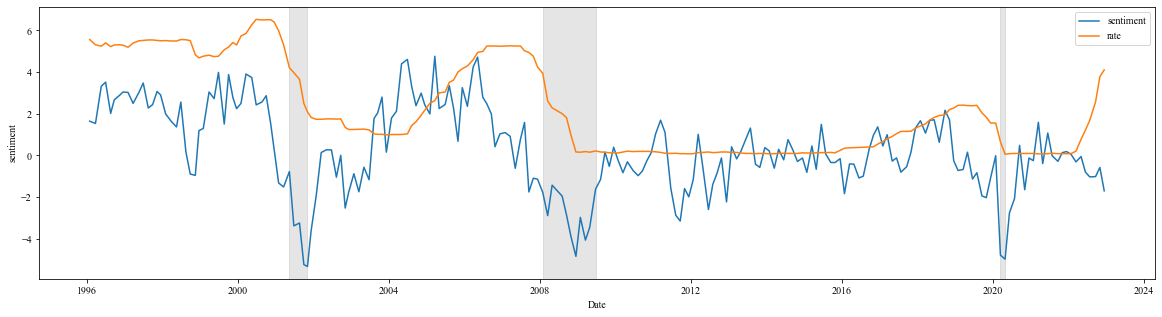

In [28]:
plot_series(cleaned_mins.sentiment, [cleaned_mins.rate])

# Probit Model 1
Impact of sentiment on predicting rate change given the previous change 

In [218]:
from sklearn.preprocessing import StandardScaler

df_main = cleaned_mins[["rate", "rate_change", "sentiment"]]
df_main["sentiment"] = StandardScaler().fit_transform(df_main[["sentiment"]])
df_main["rate_t"] = df_main["rate"].shift(1)
df_main["sentiment_t"] = df_main["sentiment"].shift(1)
df_main["rate_change_t"] = df_main["rate_change"].shift(1)
df_main = df_main.dropna()
df_main.head()

,rate,rate_change,sentiment,rate_t,sentiment_t,rate_change_t
1996-05-21,5.24,0,1.502007,5.31,0.620430,-25
1996-07-02,5.40,0,1.600861,5.24,1.502007,0
1996-08-20,5.22,0,0.860090,5.40,1.600861,0
1996-09-24,5.30,0,1.181364,5.22,0.860090,0
1996-11-13,5.31,0,1.286438,5.30,1.181364,0


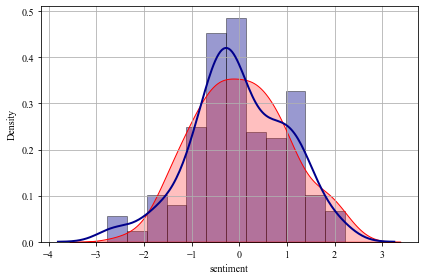

In [219]:
check_distribution(df_main["sentiment"])

Now I should have the rate change at t+1 (dependent). The rate change and sentiment at t as independent variables

\begin{equation}
\Delta r_{t+1} = \alpha_{1}\Delta r_{t} + \alpha_{2}Sentiment_{t} + \epsilon_{t+1}
\end{equation}

In [220]:
# m1 = sm.api.OLS(df_1["rate_change"], sm.api.add_constant(df_1[["rate_change_t", "sentiment_t"]])).fit()
# print(m1.summary())

In [221]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from stargazer.stargazer import Stargazer

mod_prob_0 = OrderedModel(df_main["rate_change"],
                        df_main[["rate_change_t"]],
                        distr='probit')

res_prob_0 = mod_prob_0.fit(method='bfgs')

print(res_prob_0.summary())

Optimization terminated successfully.
         Current function value: 0.510378
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
                             OrderedModel Results                             
Dep. Variable:            rate_change   Log-Likelihood:                -108.71
Model:                   OrderedModel   AIC:                             223.4
Method:            Maximum Likelihood   BIC:                             233.5
Date:                Wed, 08 Mar 2023                                         
Time:                        22:19:32                                         
No. Observations:                 213                                         
Df Residuals:                     210                                         
Df Model:                           3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

In [222]:
mod_prob_1 = OrderedModel(df_main["rate_change"],
                        df_main[["rate_change_t", "sentiment_t"]],
                        distr='probit')

res_prob_1 = mod_prob_1.fit(method='bfgs')

print(res_prob_1.summary())

Optimization terminated successfully.
         Current function value: 0.457978
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
                             OrderedModel Results                             
Dep. Variable:            rate_change   Log-Likelihood:                -97.549
Model:                   OrderedModel   AIC:                             203.1
Method:            Maximum Likelihood   BIC:                             216.5
Date:                Wed, 08 Mar 2023                                         
Time:                        22:19:32                                         
No. Observations:                 213                                         
Df Residuals:                     209                                         
Df Model:                           4                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

## Probit Model 2
Now lets try a taylor type rule 

In [240]:
# Retrieve data for inflation (CPI) & GDP
macro = pd.DataFrame()
macro["inflation"] = fred.get_series('CPIAUCSL').pct_change()*100
macro["gdp"] = fred.get_series('GDPC1')
macro["pot_gdp"] = fred.get_series('GDPPOT')
macro["gdp_growth"] = macro["gdp"].pct_change()*100
macro["output_gap"] = (1-(macro.gdp/macro.pot_gdp))*100
macro["unemployment"] = fred.get_series('UNRATE')
macro["nat_unemploy"] = fred.get_series('NROU')

# Upsampling data- monthly to daily, for analysis
start_date = minutes.index.min()
end_date = minutes.index.max() + pd.DateOffset(day=31)

dates = pd.date_range(start_date, end_date, freq="D")
dates.name = "Date"
macro = macro.reindex(dates, method="ffill")

macro = macro.ffill().dropna()
macro.tail()

,inflation,gdp,pot_gdp,gdp_growth,output_gap,unemployment,nat_unemploy
Date,,,,,,,
2022-12-27,0.13128,20187.495,20295.47,0.0,0.532015,3.5,4.43176
2022-12-28,0.13128,20187.495,20295.47,0.0,0.532015,3.5,4.43176
2022-12-29,0.13128,20187.495,20295.47,0.0,0.532015,3.5,4.43176
2022-12-30,0.13128,20187.495,20295.47,0.0,0.532015,3.5,4.43176
2022-12-31,0.13128,20187.495,20295.47,0.0,0.532015,3.5,4.43176


In [250]:
macro["un_gap"] = (macro.unemployment-macro.nat_unemploy)/macro.nat_unemploy

In [255]:
df_1 = df_main.join(macro)
df_1["un_gap_t"] = df_1["un_gap"].shift(1)
df_1["un_rate_t"] = df_1["unemployment"].shift(1)
df_1["gdp_growth_t"] = df_1["gdp_growth"].shift(1)
df_1["inflation_t"] = df_1["inflation"].shift(1)
df_1["output_gap_t"] = df_1["output_gap"].shift(1)
df_1 = df_1.dropna()
df_1.tail()

,rate,rate_change,sentiment,rate_t,sentiment_t,rate_change_t,inflation,gdp,pot_gdp,gdp_growth,output_gap,unemployment,nat_unemploy,un_gap,un_gap_t,un_rate_t,gdp_growth_t,inflation_t,output_gap_t
2022-06-15,1.21,25,-0.532604,0.77,-0.163059,25,1.187909,19895.271,20101.18,0.000000,1.024363,3.6,4.440214,-0.189228,-0.189228,3.6,0.000000,0.920616,1.024363
2022-07-27,1.68,25,-0.646341,1.21,-0.532604,25,-0.033930,20054.663,20197.94,0.801155,0.709364,3.5,4.435784,-0.210962,-0.189228,3.6,0.000000,1.187909,1.024363
2022-09-21,2.56,25,-0.640126,1.68,-0.646341,25,0.412773,20054.663,20197.94,0.000000,0.709364,3.5,4.435784,-0.210962,-0.210962,3.5,0.801155,-0.033930,0.709364
2022-11-02,3.78,25,-0.422391,2.56,-0.640126,25,0.205043,20187.495,20295.47,0.000000,0.532015,3.6,4.431760,-0.187682,-0.210962,3.5,0.000000,0.412773,0.709364
2022-12-14,4.10,25,-0.977895,3.78,-0.422391,25,0.131280,20187.495,20295.47,0.000000,0.532015,3.5,4.431760,-0.210246,-0.187682,3.6,0.000000,0.205043,0.532015


In [239]:
m1 = sm.regression.linear_model.OLS(df_1["rate_change"], df_1[["rate_change_t"]]).fit()
m2 = sm.regression.linear_model.OLS(df_1["rate_change"], df_1[["rate_change_t", "sentiment_t"]]).fit()
m4 = sm.regression.linear_model.OLS(df_1["rate_change"], df_1[["rate_change_t", "inflation_t", "gdp_growth_t"]]).fit()
m3 = sm.regression.linear_model.OLS(df_1["rate_change"], df_1[["rate_change_t", "sentiment_t", "inflation_t", "gdp_growth_t"]]).fit()

stargaze = Stargazer([m1, m2, m4, m3])
stargaze.custom_columns(['Naive Model', 'Sentiment', "Taylor Rule", "Sentiment-Taylor Rule"], [1,1,1,1])
stargaze.covariate_order(['rate_change_t', 'sentiment_t', 'inflation_t', 'gdp_growth_t'])
stargaze.rename_covariates({"rate_change_t":"Previous Rate", 
                            "sentiment_t":"Sentiment", 
                            "inflation_t":"Inflation", 
                            "gdp_growth_t":"GDP Growth"})
stargaze.title('OLS Results')
stargaze

In [134]:
mean_by_year = df_1.groupby(df_1.index.year).mean()
mean_by_year["rate_change"] = pd.cut(mean_by_year["rate"].diff(), bins=[-float("inf"), -0.25, 0.25, float("inf")], labels=[-25, 0, 25]).dropna()
mean_by_year["rate_change_t"] = mean_by_year["rate_change"].shift(1)
mean_by_year = mean_by_year.dropna()

mean_by_year.head()

,rate,sentiment,rate_t,sentiment_t,inflation,gdp_growth,inflation_t,gdp_growth_t,rate_change,rate_change_t
1998,5.32750,0.298114,5.43000,0.404083,0.107275,1.198538,0.092153,1.103857,0,0
1999,5.00750,1.187646,4.93000,1.122512,0.119466,1.226127,0.112626,1.222804,-25,0
2000,6.28750,1.086859,6.15000,1.207893,0.292038,0.781615,0.293026,0.912667,25,-25
2001,3.69000,-1.646939,4.26250,-1.405117,0.121498,0.128241,0.157242,0.167872,-25,25
2002,1.62875,-0.543171,1.70125,-0.658804,0.174012,0.494479,0.146309,0.512811,-25,-25


In [135]:
df_1.to_csv("thesis_data.csv", index = True)

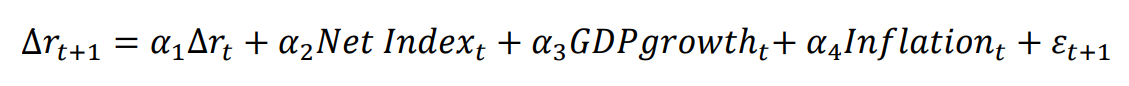

<AxesSubplot:>

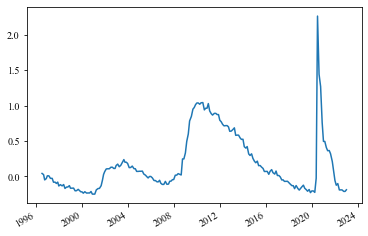

In [253]:
df_1.un_gap_t.plot()

In [257]:
mod_prob_macro = OrderedModel(df_1["rate_change"],
                        df_1[["rate_change_t", "inflation_t", "un_rate_t"]],
                        distr='probit')

res_prob_macro = mod_prob_macro.fit(method='bfgs')

print(res_prob_macro.summary())

Optimization terminated successfully.
         Current function value: 0.498562
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
                             OrderedModel Results                             
Dep. Variable:            rate_change   Log-Likelihood:                -105.70
Model:                   OrderedModel   AIC:                             221.4
Method:            Maximum Likelihood   BIC:                             238.2
Date:                Thu, 09 Mar 2023                                         
Time:                        10:54:02                                         
No. Observations:                 212                                         
Df Residuals:                     207                                         
Df Model:                           5                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [245]:
mod_prob_2 = OrderedModel(df_1["rate_change"],
                        df_1[["rate_change_t", "sentiment_t", "inflation_t", "un_gap_t"]],
                        distr='probit')

res_prob_2 = mod_prob_2.fit(method='bfgs')

print(res_prob_2.summary())

Optimization terminated successfully.
         Current function value: 0.443372
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:            rate_change   Log-Likelihood:                -93.995
Model:                   OrderedModel   AIC:                             200.0
Method:            Maximum Likelihood   BIC:                             220.1
Date:                Thu, 09 Mar 2023                                         
Time:                        10:48:38                                         
No. Observations:                 212                                         
Df Residuals:                     206                                         
Df Model:                           6                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

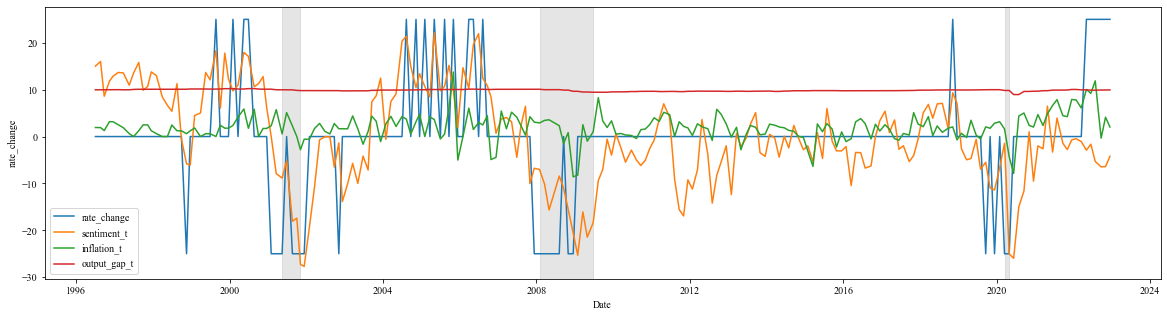

In [167]:
plot_series(df_1["rate_change"], [df_1["sentiment_t"]*10, df_1.inflation_t*10, df_1.output_gap_t*10])

In [234]:
stargaze = Stargazer([res_prob_0, res_prob_1, res_prob_macro, res_prob_2])
stargaze.custom_columns(['Naive Model', 'Sentiment', "Taylor Rule", "Sentiment-Taylor Rule"], [1,1,1,1])
stargaze.covariate_order(['rate_change_t', 'sentiment_t', 'inflation_t', 'gdp_growth_t', "-25/0", "0/25"])
stargaze.rename_covariates({"rate_change_t":"Previous Rate Change", 
                            "sentiment_t":"Sentiment", 
                            "inflation_t":"Inflation", 
                            "gdp_growth_t":"GDP Growth", 
                            "-25/0":"-25bps", 
                            "0/25":"+25bps"})
stargaze.title('Ordered Probit Results')
# stargaze.custom_omit('rsq')
# stargaze.custom_omit('adj_rsquared')
print(stargaze.render_latex())
#stargaze

\begin{table}[!htbp] \centering
  \caption{Ordered Probit Results}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable:}} \
\cr \cline{4-5}
\\[-1.8ex] & \multicolumn{1}{c}{Naive Model} & \multicolumn{1}{c}{Sentiment} & \multicolumn{1}{c}{Taylor Rule} & \multicolumn{1}{c}{Sentiment-Taylor Rule}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Previous Rate Change & 0.057$^{***}$ & 0.041$^{***}$ & 0.055$^{***}$ & 0.040$^{***}$ \\
  & (0.009) & (0.009) & (0.009) & (0.010) \\
 Sentiment & & 0.544$^{***}$ & & 0.527$^{***}$ \\
  & & (0.122) & & (0.125) \\
 Inflation & & & 0.777$^{**}$ & 0.608$^{*}$ \\
  & & & (0.345) & (0.356) \\
 GDP Growth & & & -0.086$^{}$ & -0.116$^{}$ \\
  & & & (0.110) & (0.105) \\
 -25bps & -1.558$^{***}$ & -1.753$^{***}$ & -1.436$^{***}$ & -1.655$^{***}$ \\
  & (0.142) & (0.169) & (0.151) & (0.179) \\
 +25bps & 1.119$^{***}$ & 1.237$^{***}$ & 1.139$^{***}$ & 1.248$^{***}$ \\
  & (0.

In [235]:
results = sm.regression.linear_model.OLS(df_1["rate"], df_1[["rate_t", "sentiment_t", "inflation", "gdp_growth"]]).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   rate   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              9273.
Date:                Wed, 08 Mar 2023   Prob (F-statistic):                   4.34e-233
Time:                        22:28:19   Log-Likelihood:                          14.173
No. Observations:                 212   AIC:                                     -20.35
Df Residuals:                     208   BIC:                                     -6.920
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

## 2. Latent Dirichlet Allocation (LDA) - Topic Modelling

In [69]:
cleaned_mins.text_sections[0]

['Gary H. Stern, President of the Federal Reserve Bank of Minneapolis,    with Robert T. Parry, President of the Federal Reserve Bank of San    Francisco, as alternate.\tBy unanimous vote, the following officers of the Federal OpenMarket Committee were elected to serve until the election of theirsuccessors at the first meeting of the Committee after December 31,1996, with the understanding that in the event of the discontinuanceof their official connection with the Board of Governors or with aFederal Reserve Bank, they would cease to have any official connectionwith the Federal Open Market Committee:',
 '1. The Federal Open Market Committee authorizes and directs theFederal Reserve Bank of New York, to the extent necessary to carry outthe most recent domestic policy directive adopted at a meeting of theCommittee:     (a) To buy or sell U.S. Government securities, includingsecurities of the Federal Financing Bank, and securities that aredirect obligations of, or fully guaranteed as to p

In [561]:
cleaned_mins

,chairperson,word_count,org_text,text_sections,recession,rate,taylor,text,sentiment,gap,sentiment_trials
1996-01-30,Alan Greenspan,4023,A meeting of the Federal Open Market Committee...,"[Gary H. Stern, President of the Federal Reser...",0.0,5.56,3.740709,"[gary, stern, president, federal, reserve, ban...",1.640567,1.819291,1.640567
1996-03-26,Alan Greenspan,2027,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.31,3.488009,"[turned, discussion, economic, andfinancial, o...",1.529354,1.821991,1.529354
1996-05-21,Alan Greenspan,2082,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.24,3.959658,"[turned, discussion, economic, andfinancial, o...",3.314121,1.280342,3.314121
1996-07-02,Alan Greenspan,2561,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.40,3.959658,"[turned, discussion, economic, andfinancial, o...",3.514252,1.440342,3.514252
1996-08-20,Alan Greenspan,1787,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.22,3.987449,"[turned, discussion, economic, andfinancial, o...",2.014550,1.232551,2.014550
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-15,Jerome Powell,3851,"The Federal Reserve, the central bank of the U...",[Developments in Financial Markets and Open Ma...,0.0,1.21,6.380316,"[developments, financial, markets, open, marke...",-0.804986,-5.170316,0.804986
2022-07-27,Jerome Powell,4057,"The Federal Reserve, the central bank of the U...",[Developments in Financial Markets and Open Ma...,0.0,1.68,6.380316,"[developments, financial, markets, open, marke...",-1.035248,-4.700316,1.035248
2022-09-21,Jerome Powell,3618,"The Federal Reserve, the central bank of the U...",[Developments in Financial Markets and Open Ma...,0.0,2.56,6.398823,"[developments, financial, markets, open, marke...",-1.022664,-3.838823,1.022664
2022-11-02,Jerome Powell,3781,"The Federal Reserve, the central bank of the U...",[Committee Ethics Discussion The Chair began w...,0.0,3.78,6.398823,"[ethics, discussion, chair, began, discussion,...",-0.581857,-2.618823,0.581857


In [172]:
cleaned_mins.text[0]

['gary',
 'stern',
 'president',
 'federal',
 'reserve',
 'bank',
 'minneapolis',
 'robert',
 'parry',
 'president',
 'federal',
 'reserve',
 'bank',
 'san',
 'francisco',
 'alternate',
 'unanimous',
 'vote',
 'following',
 'officers',
 'federal',
 'openmarket',
 'elected',
 'serve',
 'election',
 'theirsuccessors',
 'first',
 'meeting',
 'december',
 'understanding',
 'event',
 'discontinuanceof',
 'official',
 'connection',
 'board',
 'governors',
 'afederal',
 'reserve',
 'bank',
 'cease',
 'official',
 'connectionwith',
 'federal',
 'open',
 'market',
 'federal',
 'open',
 'market',
 'authorizes',
 'directs',
 'thefederal',
 'reserve',
 'bank',
 'new',
 'york',
 'extent',
 'necessary',
 'carry',
 'outthe',
 'recent',
 'domestic',
 'policy',
 'directive',
 'adopted',
 'meeting',
 'thecommittee',
 'buy',
 'sell',
 'government',
 'securities',
 'includingsecurities',
 'federal',
 'financing',
 'bank',
 'securities',
 'aredirect',
 'obligations',
 'fully',
 'guaranteed',
 'principal',


In [ ]:
vectorizer = CountVectorizer(tokenizer=return_self,lowercase=False,preprocessor=return_self)
bag_of_words = vectorizer.fit_transform((doc.stem for doc in paras))

num_topics = 6

lda_model = LatentDirichletAllocation(n_components = num_topics,
                                    max_iter = 20,
                                    #doc_topic_prior = 0.5,
                                    learning_method = 'online',
                                    random_state =10,
                                    n_jobs=-1)

lda_transform = lda_model.fit_transform(bag_of_words)

def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    
    return topics

In [288]:
# Form dictionary by mapping word IDs to words
ID2word = corpora.Dictionary(cleaned_mins["text"])

# Set up Bag of Words and TFIDF
corpus = [ID2word.doc2bow(doc) for doc in cleaned_mins["text"]]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=ID2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [289]:
for topic_id, topic in lda_model.show_topics(num_topics=6, num_words=10, formatted=False):
    print("Topic", topic_id, ":", [word for word, prob in topic])

Topic 0 : ['inflation', 'policy', 'rate', 'market', 'percent', 'federal', 'economic', 'remained', 'continued', 'conditions']
Topic 1 : ['foreign', 'open', 'bank', 'market', 'federal', 'december', 'transactions', 'securities', 'shall', 'currency']
Topic 2 : ['bilateral', 'disuse', 'monthsafter', 'secondarymarket', 'asignificant', 'majorcurrencies', 'andoctober', 'inaverage', 'uncomfortable', 'lapse']
Topic 3 : ['growth', 'prices', 'quarter', 'markets', 'economic', 'inflation', 'reserve', 'period', 'market', 'months']
Topic 4 : ['growth', 'inflation', 'economic', 'prices', 'year', 'spending', 'consumer', 'quarter', 'business', 'policy']
Topic 5 : ['inflation', 'economic', 'rate', 'market', 'federal', 'policy', 'prices', 'financial', 'conditions', 'continued']


In [290]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [291]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, ID2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.129491  0.004399       1        1  49.034891
4     -0.049438 -0.094060       2        1  22.912958
0     -0.186176 -0.030820       3        1  19.950351
1     -0.012392  0.231297       4        1   4.812751
3      0.046634 -0.043809       5        1   3.248640
2      0.330863 -0.067007       6        1   0.040409, topic_info=                  Term         Freq        Total Category  logprob  loglift
617            foreign  2403.000000  2403.000000  Default  30.0000  30.0000
884             market  6464.000000  6464.000000  Default  29.0000  29.0000
581            federal  5576.000000  5576.000000  Default  28.0000  28.0000
679             growth  5250.000000  5250.000000  Default  27.0000  27.0000
1325        securities  2832.000000  2832.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
7838  theestablishment     0.078205     1.130521   Topic6  -8.2028   5.1428
7596         bilateral     0.228772     4.584685   Topic6  -7.1294   4.8161
1880         inaverage     0.129057     2.255870   Topic6  -7.7019   4.9528
7870     uncomfortable     0.112839     3.655167   Topic6  -7.8362   4.3359
7708             lapse     0.082366     2.388800   Topic6  -8.1510   4.4465

[513 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
7         5  0.862849  acceptances
12        1  0.430655      account
12        2  0.089182      account
12        3  0.152548      account
12        4  0.296882      account
...     ...       ...          ...
1702      1  0.123143         york
1702      2  0.142298         york
1702      3  0.082095         york
1702      4  0.582875         york
1702      5  0.068413         york

[1100 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 2, 4, 3])

## 3. FinBERT Sentiment

In [139]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

#nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer.encode_plus)
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer.encode_plus(text,
                                                                                    add_special_tokens = True, # add [CLS], [SEP]
                                                                                    max_length = 512,
                                                                                    truncation = True,
                                                                                    pad_to_max_length = True, # add [PAD] tokens
                                                                                    return_attention_mask = True, # add attention mask to not focus on pad tokens
                                                                                   ))

In [132]:
cleaned_mins.text

1996-01-30    [gary, stern, president, federal, reserve, ban...
1996-03-26    [turned, discussion, economic, andfinancial, o...
1996-05-21    [turned, discussion, economic, andfinancial, o...
1996-07-02    [turned, discussion, economic, andfinancial, o...
1996-08-20    [turned, discussion, economic, andfinancial, o...
                                    ...                        
2022-06-15    [developments, financial, markets, open, marke...
2022-07-27    [developments, financial, markets, open, marke...
2022-09-21    [developments, financial, markets, open, marke...
2022-11-02    [ethics, discussion, chair, began, discussion,...
2022-12-14    [developments, financial, markets, open, marke...
Name: text, Length: 215, dtype: object

In [133]:
cleaned_mins.text_sections.loc["2007-05-09 00:00:00":]

2007-05-09    [The Manager of the System Open Market Account...
2007-06-28    [The information  reviewed at the June meeting...
2007-08-07    [The Manager of the System Open Market Account...
2007-09-18    [The Manager of the System Open Market Account...
2007-10-31    [The Manager of the System Open Market Account...
                                    ...                        
2022-06-15    [Developments in Financial Markets and Open Ma...
2022-07-27    [Developments in Financial Markets and Open Ma...
2022-09-21    [Developments in Financial Markets and Open Ma...
2022-11-02    [Committee Ethics Discussion The Chair began w...
2022-12-14    [Developments in Financial Markets and Open Ma...
Name: text_sections, Length: 125, dtype: object

In [140]:
#sentiments = []
for num, minute in enumerate(cleaned_mins.text_sections.loc["2007-05-09 00:00:00":]):
    #2007-05-09 00:00:00 error with len
    sentiment = nlp(minute)
    print(cleaned_mins.loc["2007-05-09 00:00:00":].index[num], "\n", sentiment)
    sentiments.append(sentiment)

TypeError: 'BatchEncoding' object is not callable

In [142]:
#for i in sentiments[0][:5]:
finbert_sentiment = []
for i in sentiments:
    sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    mapped_sentiments = [sentiment_map[j['label']] for j in i]
    total = sum(mapped_sentiments)/len(mapped_sentiments)
    finbert_sentiment.append(total)
    
finbert_sentiment = pd.DataFrame(finbert_sentiment, index = cleaned_mins.head(len(finbert_sentiment)).index)
finbert_sentiment.head()

,0
1996-01-30,0.016949
1996-03-26,0.307692
1996-05-21,0.185185
1996-07-02,0.000000
1996-08-20,-0.166667


In [223]:
cleaned_mins

,chairperson,word_count,org_text,text_sections,recession,rate,taylor,text,sentiment,gap,sentiment_trials
1996-01-30,Alan Greenspan,4023,A meeting of the Federal Open Market Committee...,"[Gary H. Stern, President of the Federal Reser...",0.0,5.56,3.740709,"[gary, stern, president, federal, reserve, ban...",-1.640567,1.819291,1.640567
1996-03-26,Alan Greenspan,2027,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.31,3.488009,"[turned, discussion, economic, andfinancial, o...",-1.529354,1.821991,1.529354
1996-05-21,Alan Greenspan,2082,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.24,3.959658,"[turned, discussion, economic, andfinancial, o...",-3.314121,1.280342,3.314121
1996-07-02,Alan Greenspan,2561,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.40,3.959658,"[turned, discussion, economic, andfinancial, o...",-3.514252,1.440342,3.514252
1996-08-20,Alan Greenspan,1787,A meeting of the Federal Open Market Committee...,[The Committee then turned to a discussion of ...,0.0,5.22,3.987449,"[turned, discussion, economic, andfinancial, o...",-2.014550,1.232551,2.014550
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-15,Jerome Powell,3851,"The Federal Reserve, the central bank of the U...",[Developments in Financial Markets and Open Ma...,0.0,1.21,6.380316,"[developments, financial, markets, open, marke...",0.804986,-5.170316,0.804986
2022-07-27,Jerome Powell,4057,"The Federal Reserve, the central bank of the U...",[Developments in Financial Markets and Open Ma...,0.0,1.68,6.380316,"[developments, financial, markets, open, marke...",1.035248,-4.700316,1.035248
2022-09-21,Jerome Powell,3618,"The Federal Reserve, the central bank of the U...",[Developments in Financial Markets and Open Ma...,0.0,2.56,6.398823,"[developments, financial, markets, open, marke...",1.022664,-3.838823,1.022664
2022-11-02,Jerome Powell,3781,"The Federal Reserve, the central bank of the U...",[Committee Ethics Discussion The Chair began w...,0.0,3.78,6.398823,"[ethics, discussion, chair, began, discussion,...",0.581857,-2.618823,0.581857


## Financial Markets Data

In [362]:
tickers = ["ZQ=F", "^GSPC", "EEM"]
label = ["FFR-Futures", "SP500", "Emerging_Markets_ETF"]
financials = pd.DataFrame()

for num, ticker in enumerate(tickers): 
    i = yf.Ticker(ticker)
    data = i.history(period = "max")
    financials[f"{label[num]} Returns"] = data["Close"].pct_change()*100
    #financials[f"{label[num]} Volatility"] = financials[f"{label[num]} Returns"].std()
    financials[f"{label[num]} Volume"] = data["Volume"]

financials = financials.dropna()
financials["Minutes"] = financials.index.isin(cleaned_mins.index).astype(int)
financials.tail()

,FFR-Futures Returns,FFR-Futures Volume,SP500 Returns,SP500 Volume,Emerging_Markets_ETF Returns,Emerging_Markets_ETF Volume,Minutes
Date,,,,,,,
2023-02-03,0.000000,43845,-1.035461,4.694510e+09,-1.777986,42340400.0,0
2023-02-06,-0.002614,42795,-0.614046,4.114240e+09,-1.467716,41471500.0,0
2023-02-07,0.005237,21541,1.287251,4.355860e+09,0.397219,31941600.0,0
2023-02-08,0.000000,21541,-1.108072,4.029820e+09,-0.123638,38254600.0,0
2023-02-09,-0.466310,50975,-0.517254,1.578989e+09,0.544938,17454431.0,0


In [363]:
financials.iloc[:,0:9]

,FFR-Futures Returns,FFR-Futures Volume,SP500 Returns,SP500 Volume,Emerging_Markets_ETF Returns,Emerging_Markets_ETF Volume,Minutes
Date,,,,,,,
2003-04-15,0.005068,270,0.630347,1.460200e+09,1.188112,421200.0,0
2003-04-17,0.000000,399,1.553573,1.430600e+09,0.715813,17100.0,0
2003-04-21,-0.005068,151,-0.175699,1.118700e+09,-0.038464,72900.0,0
2003-04-22,-0.005060,985,2.170378,1.631200e+09,0.336329,19800.0,0
2003-04-23,0.000000,985,0.839398,1.667200e+09,0.469199,31500.0,0
...,...,...,...,...,...,...,...
2023-02-03,0.000000,43845,-1.035461,4.694510e+09,-1.777986,42340400.0,0
2023-02-06,-0.002614,42795,-0.614046,4.114240e+09,-1.467716,41471500.0,0
2023-02-07,0.005237,21541,1.287251,4.355860e+09,0.397219,31941600.0,0


In [364]:
financial_mins = financials.loc[financials["Minutes"] == 1]
non_financial_mins = financials.loc[financials["Minutes"] == 0]
financial_mins.describe()

,FFR-Futures Returns,FFR-Futures Volume,SP500 Returns,SP500 Volume,Emerging_Markets_ETF Returns,Emerging_Markets_ETF Volume,Minutes
count,156.000000,156.000000,156.000000,1.560000e+02,156.000000,1.560000e+02,156.0
mean,-0.001123,24064.641026,0.317618,3.894546e+09,0.595321,6.184894e+07,1.0
std,0.022575,48435.570151,1.254165,1.453357e+09,1.929346,3.859622e+07,0.0
min,-0.239019,2.000000,-2.939044,1.132300e+09,-4.235350,1.098000e+05,1.0
25%,0.000000,2788.250000,-0.385963,3.248798e+09,-0.507205,4.035825e+07,1.0
50%,0.000000,7996.500000,0.097679,3.929180e+09,0.496909,6.048210e+07,1.0
75%,0.000624,22100.500000,0.851593,4.544178e+09,1.383941,8.212160e+07,1.0
max,0.063149,370896.000000,5.136026,9.976520e+09,8.052899,2.040462e+08,1.0


In [365]:
non_financial_mins.describe()

,FFR-Futures Returns,FFR-Futures Volume,SP500 Returns,SP500 Volume,Emerging_Markets_ETF Returns,Emerging_Markets_ETF Volume,Minutes
count,4823.000000,4823.000000,4823.000000,4.823000e+03,4823.000000,4.823000e+03,4823.0
mean,-0.000762,8065.712627,0.030383,3.635845e+09,0.033380,4.954925e+07,0.0
std,0.036327,16281.031822,1.207234,1.365352e+09,1.774787,3.253155e+07,0.0
min,-0.727406,0.000000,-11.984055,3.560700e+08,-16.166220,1.710000e+04,0.0
25%,0.000000,1086.000000,-0.414108,2.879645e+09,-0.788060,3.014900e+07,0.0
50%,0.000000,3268.000000,0.070910,3.587670e+09,0.094149,4.764980e+07,0.0
75%,0.000000,8304.000000,0.560307,4.296200e+09,0.895387,6.657875e+07,0.0
max,1.025348,328884.000000,11.580037,1.145623e+10,22.769885,2.486821e+08,0.0


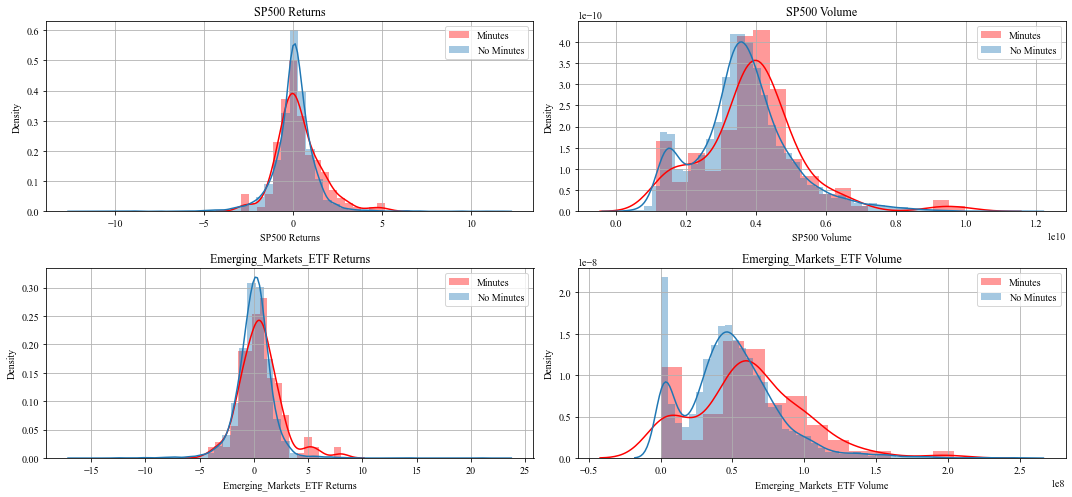

In [367]:
plt.figure(figsize = (15,10))

for num, ticker in enumerate(financial_mins.iloc[:,2:6]):
    plt.subplot(3, 2, num+1)
    plt.title(ticker)
    sns.distplot(financial_mins[ticker], color = 'red', label = "Minutes")
    sns.distplot(non_financial_mins[ticker], label = "No Minutes")
    plt.legend()
    plt.grid()
    plt.tight_layout()

might be more useful with 5/10 minute data rather than daily. 

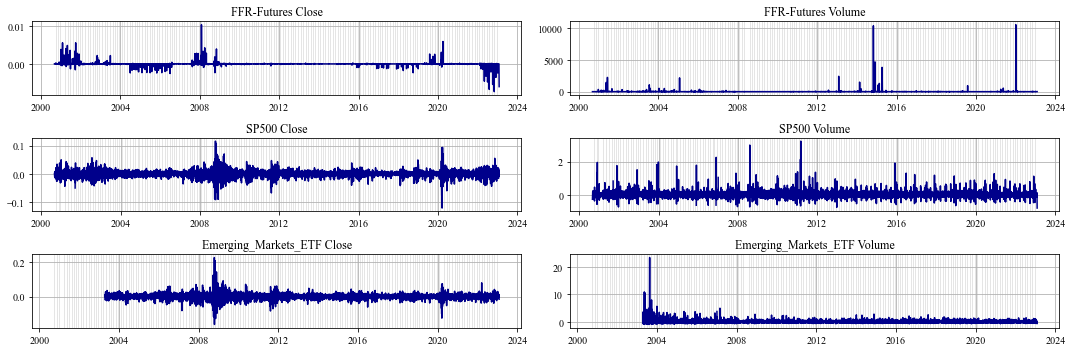

In [235]:
plt.figure(figsize = (15,5))

mins = financials.loc[financials["Minutes"] == 1].index
threshold = pd.Timedelta('1 days')
blocks = []
start = mins[0]
end = mins[0]
for i in range(1, len(mins)):
    if mins[i] - mins[i-1] <= threshold:
        end = mins[i]
    else:
        blocks.append((start, end))
        start = mins[i]
        end = mins[i]
blocks.append((start, end))

for i, col in enumerate(financials.iloc[:,:6]):
    plt.subplot(3, 2, i+1)
    plt.title(col)
    plt.plot(financials[col], color = "darkblue")
    for block in blocks:
        plt.axvspan(block[0], block[1], color="grey", alpha=0.2)
    plt.grid()
    plt.tight_layout()

Follow Tadle approach by using minute level data, combining all historical data for mean and std 

In [219]:
# Retrieve data for the federal funds rate
fed_funds_rate = fred.get_series('FEDFUNDS')

# Retrieve data for inflation (CPI)
cpi = fred.get_series('CPIAUCSL')

# Retrieve data for real GDP
gdp = fred.get_series('GDPC1')

# Retrieve data for unemployment rate
unrate = fred.get_series('UNRATE')

# Calculate 12-month trailing average inflation rate
inflation = cpi.pct_change(12).rolling(12).mean()*100

# Calculate real GDP growth rate
gdp_growth = gdp.pct_change()*100

# Calculate natural rate of interest
r_star = 0.02 + (0.5 * inflation) + (0.5 * gdp_growth)

# Calculate Taylor rule with constant coefficients
taylor1 = 1.5 + (1 * inflation) - (1 * unrate)

# Calculate Taylor rule with time-varying coefficients
taylor2 = r_star + (0.5 * inflation) - (1 * unrate)

# Calculate Taylor rule with interest rate smoothing
taylor3 = 1.5 + (1 * inflation) - (1 * unrate) - (0.5 * (fed_funds_rate - 1.5))

# Calculate Taylor rule with autoregressive error term
#taylor4 = 1.5 + (1 * inflation.shift(1)) + (0.5 * (fed_funds_rate - 1.5)) + (0.5 * taylor4.shift(1))

# Create a DataFrame to store the Taylor rules
taylor_rules = pd.DataFrame({
    'taylor1': taylor1,
    'taylor2': taylor2,
    'taylor3': taylor3
    #'taylor4': taylor4
})

# Print the last 5 rows of the DataFrame
print(taylor_rules.tail())

             taylor1  taylor2   taylor3
2022-09-01  5.906536      NaN  5.376536
2022-10-01  5.833597  4.71119  5.043597
2022-11-01  5.956344      NaN  4.816344
2022-12-01  5.993884      NaN  4.693884
2023-01-01  5.989874      NaN  4.574874


<AxesSubplot:>

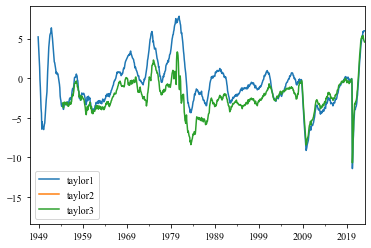

In [220]:
taylor_rules.plot()

## Intraday Data 

In [78]:
sheet_to_df_map = pd.read_excel(r"C:\Users\Csome\Downloads\Intraday data Carl.xlsx", sheet_name=None)
sheet_to_df_map.keys()

In [144]:
cleaned_mins["sentiment"]

1996-01-30    1.640567
1996-03-26    1.529354
1996-05-21    3.314121
1996-07-02    3.514252
1996-08-20    2.014550
                ...   
2022-06-15   -0.804986
2022-07-27   -1.035248
2022-09-21   -1.022664
2022-11-02   -0.581857
2022-12-14   -1.706485
Name: sentiment, Length: 215, dtype: float64

In [145]:
sheet_to_df_map["fed sentiment"]

,Date,Latest
0,2023-01-04,15.73
1,2022-11-23,11.25
2,2022-10-12,2.30
3,2022-08-17,-3.28
4,2022-07-06,8.70
...,...,...
180,2000-08-24,8.15
181,2000-06-29,32.19
182,2000-05-18,37.48
183,2000-03-23,15.33


In [100]:
sheet_to_df_map["VIX"].Date

0      2023-02-09 12:15:00
1      2023-02-09 11:45:00
2      2023-02-09 11:15:00
3      2023-02-09 10:45:00
4      2023-02-09 10:15:00
               ...        
4634   2022-05-31 10:15:00
4635   2022-05-31 09:45:00
4636   2022-05-31 09:15:00
4637   2022-05-31 08:45:00
4638   2022-05-31 08:15:00
Name: Date, Length: 4639, dtype: datetime64[ns]

In [138]:
vix = pd.DataFrame(sheet_to_df_map["VIX"]).set_index("Date")
vix["Vol"] = vix.High - vix.Low
vix["Minutes"] = vix["dates"].isin(cleaned_mins.index).astype(int)
vix.head()

KeyError: 'dates'

In [135]:
new_dates = []
for i in vix.index:
    new_date = i.date()
    new_dates.append(new_date)
vix["dates"] = new_dates

In [137]:
vix

,Open,High,Low,Close,Vol,dates
Date,,,,,,
2023-02-09 12:15:00,19.20,19.20,19.19,19.19,0.01,2023-02-09
2023-02-09 11:45:00,19.20,19.22,19.17,19.20,0.05,2023-02-09
2023-02-09 11:15:00,19.12,19.22,19.12,19.20,0.10,2023-02-09
2023-02-09 10:45:00,19.09,19.12,19.05,19.12,0.07,2023-02-09
2023-02-09 10:15:00,19.10,19.14,19.08,19.09,0.06,2023-02-09
...,...,...,...,...,...,...
2022-05-31 10:15:00,27.65,28.21,27.59,28.13,0.62,2022-05-31
2022-05-31 09:45:00,27.35,27.69,27.34,27.64,0.35,2022-05-31
2022-05-31 09:15:00,27.52,27.52,27.30,27.35,0.22,2022-05-31


<AxesSubplot:xlabel='Date'>

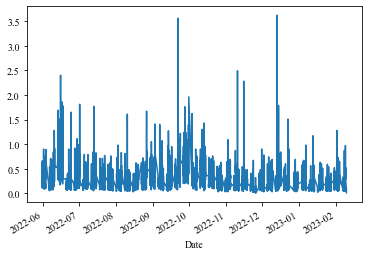

In [108]:
vix.Vol.plot()

In [22]:
# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]